In [19]:
from __future__ import division, print_function
import sympy
import sympy.physics.mechanics as mech
import pylab as pl
import scipy.integrate
import numpy
import re

import quaternion
import sympy_utils

sympy.init_printing()
mech.init_vprinting()

# Frame and Coordinate Definitions

In [2]:
t, g = sympy.symbols('t, g')
q_nr_coord = sympy.Matrix(mech.dynamicsymbols('q_0:4'))
q_nr = q_nr_coord
alpha_b_coord = sympy.Matrix(mech.dynamicsymbols('alpha_x:z'))
omega_b_coord = sympy.Matrix(mech.dynamicsymbols('omega_x:z'))
a_b_coord = sympy.Matrix(mech.dynamicsymbols('a_x:z'))
b_b_coord = sympy.Matrix(mech.dynamicsymbols('b_x:z'))
m_n_coord = sympy.Matrix(mech.dynamicsymbols('m_N, m_E, m_D'))

# for position, just focusing on attitude currently
#p_n_coord = sympy.Matrix(mech.dynamicsymbols('p_N, p_E, p_D'))
#v_n_coord = sympy.Matrix(mech.dynamicsymbols('v_N, v_E, v_D'))
#c_b_coord = sympy.Matrix(mech.dynamicsymbols('c_x:z'))

frame_n = mech.ReferenceFrame('n')
frame_r = frame_n.orientnew('r', 'Quaternion', q_nr_coord)
frame_b = frame_r.orientnew('b', 'Body', alpha_b_coord, '123')

a_b = a_b_coord[0]*frame_b.x + a_b_coord[1]*frame_b.y + a_b_coord[2]*frame_b.z
omega_nb = (omega_b_coord[0] + b_b_coord[0])*frame_b.x +     (omega_b_coord[1] + b_b_coord[1])*frame_b.y +     (omega_b_coord[2] + b_b_coord[2])*frame_b.z
omega_nr = omega_b_coord[0]*frame_r.x + omega_b_coord[1]*frame_r.y + omega_b_coord[2]*frame_r.z

# for position, just focusing on attitude currently
#v_n = v_n_coord[0]*frame_n.x + v_n_coord[1]*frame_n.y + v_n_coord[2]*frame_n.z
#p_n = p_n_coord[0]*frame_n.x + p_n_coord[1]*frame_n.y + p_n_coord[2]*frame_n.z

m_n = m_n_coord[0]*frame_n.x + m_n_coord[1]*frame_n.y + m_n_coord[2]*frame_n.z 

coords = list(q_nr_coord) + list(m_n_coord) + list(omega_b_coord) + list(a_b_coord)

sub_x0 = { alpha_b_coord[i] : 0 for i in range(3)}
sub_x0.update({b_b_coord[i] : 0 for i in range(3)})
sub_no_t = {_v: sympy.Symbol(str(_v).replace('(t)','')) for _v in coords}

In [3]:
q_nr.dot(q_nr).diff(t)

Body frame is rotating at measured angular velocity.


In [4]:
omega_nb

In [5]:
omega_nr

We solve for the reference frame kinematics.

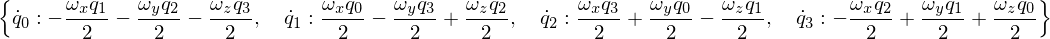

In [6]:
sol_q_dot = sympy.solve([(frame_r.ang_vel_in(frame_n) - omega_nr).to_matrix(frame_r)] +
            [q_nr.dot(q_nr).diff(t)],
            q_nr_coord.diff(t))
sol_q_dot = {key: sol_q_dot[key].subs(q_nr.dot(q_nr), 1) for key in sol_q_dot.keys()}
sol_q_dot

Now we solve for the alignment frame kinematics.

In [7]:
eq_alpha_dot = ((frame_b.ang_vel_in(frame_n) - omega_nb)).to_matrix(frame_b).subs(sol_q_dot).simplify()
sol_alpha_dot = sympy.solve(eq_alpha_dot, alpha_b_coord.diff(t))
sol_b_dot = {b_b_coord[i].diff(t): 0 for i in range(3)}

# State Space and Linearization

In [8]:
x = sympy.Matrix(list(alpha_b_coord) +  list(b_b_coord))
x.T

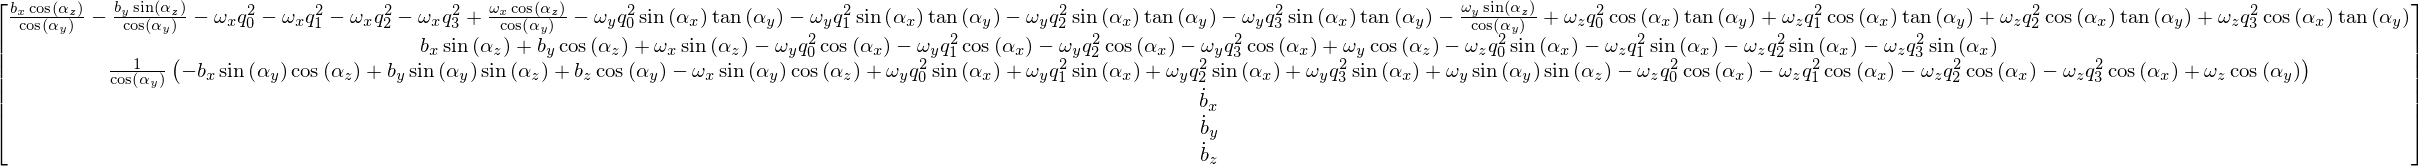

In [9]:
f = x.diff(t).subs(sol_alpha_dot)
f

There is no need to propagate the alignment errors, since our best guess is always that the alignment errors are zero.

In [10]:
f.subs(sub_x0).applyfunc(lambda e: e.simplify().subs(q_nr.dot(q_nr), 1).doit()).T

We do need the dynamics equations to get the A matrix to propagate the covariance matrix.

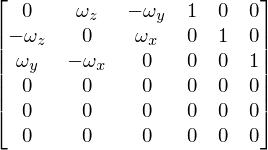

In [11]:
A = f.jacobian(x).subs(sub_x0)
A.simplify()
A = A.subs(q_nr.dot(q_nr), 1)
A

# Magnetometer

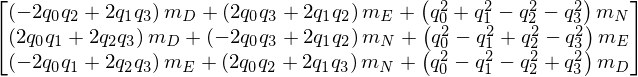

In [12]:
y_mag = m_n
y_mag.to_matrix(frame_b).subs(sub_x0)

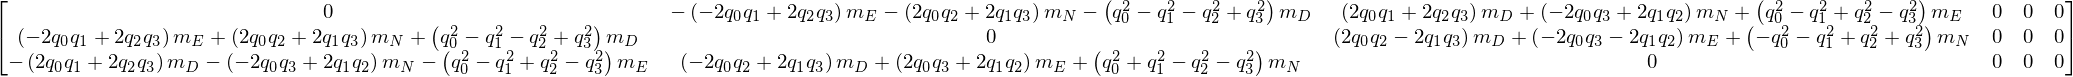

In [13]:
C_mag = y_mag.to_matrix(frame_b).jacobian(x).subs(sub_x0)
C_mag.simplify()
C_mag

# Accelerometer

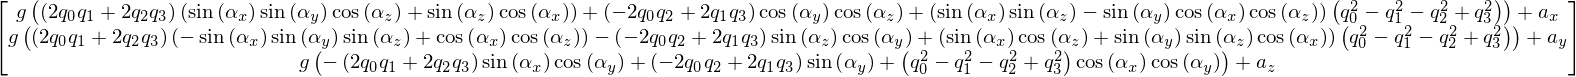

In [14]:
y_accel = g*frame_n.z + a_b_coord[0]*frame_b.x + a_b_coord[1]*frame_b.y + a_b_coord[2]*frame_b.z
y_accel.to_matrix(frame_b)

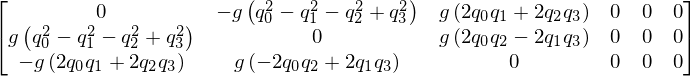

In [15]:
C_accel = y_accel.to_matrix(frame_b).jacobian(x).subs(sub_x0)
C_accel.simplify()
C_accel

# Generate Numerical Computation Routines

In [16]:
x_r = sympy.Matrix(list(q_nr) + list(alpha_b_coord) + list(b_b_coord))
u_r = sympy.Matrix(list(omega_b_coord) + list(b_b_coord.diff(t)))
f_r = x_r.diff(t).subs(sol_q_dot).subs(sol_alpha_dot)
x_def = sympy.DeferredVector('x')
u_def = sympy.DeferredVector('u')
m_def = sympy.DeferredVector('m')
a_def = sympy.DeferredVector('a')
sub_ss_r = {}
sub_ss_r.update({x_r[i]:x_def[i] for i in range(len(x_r))})
sub_ss_r.update({u_r[i]:u_def[i] for i in range(len(u_r))})
sub_ss_r.update({m_n_coord[i]:m_def[i] for i in range(len(m_n_coord))})
sub_ss_r.update({a_b_coord[i]:a_def[i] for i in range(len(a_b_coord))})
f_r_ss = f_r.subs(sub_ss_r)
use_array = [{'ImmutableMatrix': numpy.array}, "numpy"]

f_sim_r = sympy.lambdify((t, x_def, u_def), f_r_ss, use_array)
f_C_accel = sympy.lambdify((x_def, g), C_accel.subs(sub_ss_r), use_array)
f_y_accel = sympy.lambdify((x_def, g, a_def), y_accel.to_matrix(frame_b).subs(sub_x0).subs(sub_ss_r), use_array)
f_C_mag = sympy.lambdify((x_def, g, m_def), C_mag.subs(sub_ss_r), use_array)
f_y_mag = sympy.lambdify((x_def, m_def), y_mag.to_matrix(frame_b).subs(sub_x0).subs(sub_ss_r), use_array)
f_sim_est = sympy.lambdify((q_nr_coord, omega_b_coord),
                           sympy.Matrix(x_r[0:4]).diff(t).subs(sol_q_dot), use_array)
f_quat_from_euler = sympy.lambdify(alpha_b_coord,
                                   quaternion.quat_from_euler(*alpha_b_coord)) 
f_A = sympy.lambdify((x_def, u_def), A.subs(sub_ss_r), use_array)
lambda_functions = {
    'f_sim': f_sim_r,
    'f_A': f_A,
    'f_sim_est': f_sim_est,
    'f_C_accel': f_C_accel,
    'f_y_accel': f_y_accel,
    'f_C_mag': f_C_mag,
    'f_y_mag': f_y_mag,
    'f_quat_from_euler': f_quat_from_euler,
}
lambda_functions

{'f_A': <function numpy.<lambda>>,
 'f_C_accel': <function numpy.<lambda>>,
 'f_C_mag': <function numpy.<lambda>>,
 'f_quat_from_euler': <function numpy.<lambda>>,
 'f_sim': <function numpy.<lambda>>,
 'f_sim_est': <function numpy.<lambda>>,
 'f_y_accel': <function numpy.<lambda>>,
 'f_y_mag': <function numpy.<lambda>>}

# Code Generation

In [17]:
def code_gen_matrix(name, mat, sub):
    m, n = mat.shape
    s = 'Matrix<{:d}, {:d}> {:s};\n'.format(m, n, name)
    s += '{:s}.zero();\n'.format(name)
    for i in range(m):
        for j in range(n):
            val = mat[i,j].subs(sub)
            if val == 0:
                continue
            s += '{:s}({:d},{:d}) = {:s};\n'.format(name, i, j, sympy.ccode(mat[i,j].subs(sub)))
    s += '\n'
    # don't use power for squared term
    s = re.sub('pow\(([\word]+), 2\)', '\g<1>*\g<1>', s)
    return s

In [20]:
s = ''
s += code_gen_matrix('A', A, sub_no_t)
s += code_gen_matrix('C_mag', C_mag, sub_no_t)
s += code_gen_matrix('C_accel', C_accel, sub_no_t)
s += code_gen_matrix('y_accel', y_accel.to_matrix(frame_b).subs(sub_x0), sub_no_t)
s += code_gen_matrix('y_mag', y_mag.to_matrix(frame_b).subs(sub_x0), sub_no_t)
print(s)

Matrix<6, 6> A;
A.zero();
A(0,1) = omega_z;
A(0,2) = -omega_y;
A(0,3) = 1;
A(1,0) = -omega_z;
A(1,2) = omega_x;
A(1,4) = 1;
A(2,0) = omega_y;
A(2,1) = -omega_x;
A(2,5) = 1;

Matrix<3, 6> C_mag;
C_mag.zero();
C_mag(0,1) = -m_D*(q_0*q_0 - q_1*q_1 - q_2*q_2 + q_3*q_3) - m_E*(-2*q_0*q_1 + 2*q_2*q_3) - m_N*(2*q_0*q_2 + 2*q_1*q_3);
C_mag(0,2) = m_D*(2*q_0*q_1 + 2*q_2*q_3) + m_E*(q_0*q_0 - q_1*q_1 + q_2*q_2 - q_3*q_3) + m_N*(-2*q_0*q_3 + 2*q_1*q_2);
C_mag(1,0) = m_D*(q_0*q_0 - q_1*q_1 - q_2*q_2 + q_3*q_3) + m_E*(-2*q_0*q_1 + 2*q_2*q_3) + m_N*(2*q_0*q_2 + 2*q_1*q_3);
C_mag(1,2) = m_D*(2*q_0*q_2 - 2*q_1*q_3) + m_E*(-2*q_0*q_3 - 2*q_1*q_2) + m_N*(-q_0*q_0 - q_1*q_1 + q_2*q_2 + q_3*q_3);
C_mag(2,0) = -m_D*(2*q_0*q_1 + 2*q_2*q_3) - m_E*(q_0*q_0 - q_1*q_1 + q_2*q_2 - q_3*q_3) - m_N*(-2*q_0*q_3 + 2*q_1*q_2);
C_mag(2,1) = m_D*(-2*q_0*q_2 + 2*q_1*q_3) + m_E*(2*q_0*q_3 + 2*q_1*q_2) + m_N*(q_0*q_0 + q_1*q_1 - q_2*q_2 - q_3*q_3);

Matrix<3, 6> C_accel;
C_accel.zero();
C_accel(0,1) = -g*(q_0*q_0 - q_1*q_1

# Save Data

In [ ]:
sympy_utils.save(['lambda_functions'], 'deriv.pkl', locals())
sympy_utils.load('deriv.pkl')

sympy_utils.sympy_save(['C_accel', 'C_mag'], 'deriv.sympy', locals())
sympy_utils.sympy_load('deriv.sympy');